# Building and training your first GAN with PyTorch

![overviewgan](../images/overview.png "https://arxiv.org/pdf/1710.07035.pdf")

## First: The Discriminator
This guy is just like any other Neural Network

In [1]:
%%writefile discriminator.py
from torch import nn
#from utils import utils

class _D(nn.Module):
    """ Discriminator class"""
    def __init__(self, input_h_w=28):
        super(_D, self).__init__()     
        self.input_height = input_h_w
        self.input_width = input_h_w
        self.input_dim = 1
        self.output_dim = 1
        
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_height // 4) * (self.input_width // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        # initialize_weights(self)

    def forward(self, input_):
        x = self.conv(input_)
        x = x.view(-1, 128 * (self.input_height // 4) * (self.input_width // 4))
        x = self.fc(x)

        return x

Overwriting discriminator.py



    + live-coding demo, 20m: writing a supervised learning training loop
      - how do we fit this thing?
      
      - train with MNIST (or some simple dataset) using SGD
      - introduce datasets n' dataloaders: your friends
      - creating a criterion
      - in the bad old days, we made batches by hand from artisanal numpy matrices
      - writing the training loop
      - computing the loss
      - logging the loss

    + *hands-on* 

## Second: The Generator

In [2]:
%%writefile generator.py
from torch import nn
#from utils import utils

class _G(nn.Module):
    """Generator class"""
    def __init__(self, input_h_w=28, latent_v=62):
        super(_G, self).__init__()
        self.input_height = input_h_w
        self.input_width = input_h_w
        self.input_dim = latent_v
        self.output_dim = 1

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Sigmoid(),
        )
        # initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_height // 4), (self.input_width // 4))
        x = self.deconv(x)

        return x

Overwriting generator.py


A little hack on weights initialization ..

In [11]:
# TODO this should be moved to utils.py

def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

## The Data 

<div class="alert alert-block alert-success">
<b>torchvision</b> The package consists of popular datasets, model architectures, and common image transformations for computer vision.
</div>

In [3]:
import torchvision
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data

In [4]:
ts_list = [tfs.RandomAffine(0., scale=(0.75, 1.), fillcolor=0),
           tfs.Resize((28, 28)),
           tfs.Grayscale(1), tfs.ToTensor()]

In [5]:
imagenet_data = datasets.ImageFolder('../data/egyptian_text/',
                                     transform=tfs.Compose(ts_list))

data_loader = data.DataLoader(imagenet_data, batch_size=32, shuffle=True)

In [6]:
import matplotlib.pyplot as plt
import numpy as np

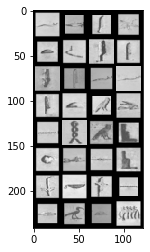

In [7]:
dataiter = iter(data_loader)
images = dataiter.next()

# show images
plt.imshow(torchvision.utils.make_grid(images[0], nrow=4).permute(1, 2, 0))

## how do we train a GAN?
![overviewgan](../images/mainloop.png "https://arxiv.org/pdf/1710.07035.pdf")

In [11]:
from discriminator import _D
from generator import _G

### Lets instantiate each network and define optimizers and loss functions

In [9]:
epochs = 10
batch_size = 32
z_dim = 64
train_hist = {'G_loss':[], 'D_loss':[]}

In [12]:
import torch
from torch import nn, optim

D = _D(input_h_w=28)
G = _G(input_h_w=28, latent_v=64) 

G_optimizer = optim.Adam(G.parameters(),
                              lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(),
                              lr=0.0002, betas=(0.5, 0.999))

BCE_loss = nn.BCELoss()

In [13]:
# Define true and false labels
y_real_, y_fake_ = Variable(torch.ones(batch_size, 1)), \
                   Variable(torch.zeros(batch_size, 1))

In [ ]:
D.train()
for epoch in range(epochs):
    G.train()
    for iter_,  (x_, _) in enumerate(data_loader):
        # create the noise source
        z_ = torch.rand((batch_size, z_dim))
        # load real sample and noise vector
        x_, z_ = Variable(x_), Variable(z_)

        # -----> update D network
        D_optimizer.zero_grad()

        D_real = D(x_)
        D_real_loss = BCE_loss(D_real, y_real_)

        G_ = G(z_)
        D_fake = D(G_)
        D_fake_loss = BCE_loss(D_fake, y_fake_)

        D_loss = D_real_loss + D_fake_loss
        train_hist['D_loss'].append(D_loss.item())

        D_loss.backward()
        D_optimizer.step()

        # -----> update G network
        G_optimizer.zero_grad()

        G_ = G(z_)
        D_fake = D(G_)
        G_loss = BCE_loss(D_fake, y_real_)
        train_hist['G_loss'].append(G_loss.item()) # TODO I think now is item()

        G_loss.backward()
        G_optimizer.step()


<div class="alert alert-block alert-info">
<b>Exercise:</b> Adding to your Discriminator, putting some label smoothing in your training loop (GAN hack!).</div>